### Uczenie reprezentacji 
Wiadome jest, że skuteczność algorytmu zależy od jakości danych wejściowych. Najbardziej trywialnym rozwiązaniem jest wykorzystanie ludzkiej wiedzy w preprocessing'u danych, aby ręcznie je  przygotować. Jednak wraz z rozwojem AI pojawiła się potrzeba inteligentnej metody ekstrakcji cech z danych, które mogą być przydatne w konkretnych zadaniach klasyfikacji / ogólnie predykcji. Celem uczenia reprezentacji jest więc nauczenie się takich reprezentacji danych, które mogą być szeroko używane. Wykorzystywane metody można zaliczyć do probabilistycznych, gdzie zadaniem jest nauczenie się rozkładu *a priori* takiego, który maksymalizuje prawdopodobieństwo (likelihood) danych na wejściu, czy też do tych wykorzystujących sieci neuronowe - narazie skupimy się na tych drugich. 

#### Autoenkoder
Taki model składa się z połączonego *enkodera* i *dekodera*, a celem jest minimalizacja funkcji rekonstrukcji (np. mean squared error). Matematycznie można to ująć tak jak poniżej $$ L(x^{(t)}, g_{\theta}(f_{\theta}(x^{(t)}))) $$ dla *enkodera* $f$ i *dekodera* $g$ a celem jest znalezienie takiego zbioru parametrów $\theta$, który minimalizuje tę stratę. Zwykle wymiar na wyjściu enkodera jest mniejszy niż danych wejściowych, aby sieć nie nauczyła się po prostu funkcji tożsamościowej. Dobrym pomysłem jest zaszumianie danych wejściowych, co stanowi dodatkową regularyzację, bo wtedy enkoder musi nauczyć się tych kluczowych dla danych cech.

Tak wytrenowany autoenkoder ma wiele zastosowań, jak np. generowanie nowych próbek z rozkładu, którego się nauczył. Wtedy na wejściu części dekodującej podajemy *embedding*, którego ta sieć być może jeszcze nie widziała (tutaj jednak lepiej jest użyć enkodera wariancyjnego *VAE*).

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import pytorch_lightning as pl
import seaborn as sns 
from torchvision.datasets import Flowers102
from torchsummary import summary
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid
from planttraits.notebook_utils import BaseCNN, train_transforms, type_transforms, train_transforms, CNNAutoencoder, CNLayer, TCNLayer, CNNVAE
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()
from torchvision.transforms import v2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
DATASET_PATH = Path('../data/study')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
torch.set_float32_matmul_precision('medium')

representation learning: https://arxiv.org/pdf/1206.5538
siamese nn: https://arxiv.org/pdf/2011.10566
diffusion models: https://erdem.pl/2023/11/step-by-step-visual-introduction-to-diffusion-models

#### Transponowane konwolucje

Przy okazji budowania autoenkodera dla zdjęć pojawia się temat *transponowanych konwolucji*, które mają zadanie przeciwne do normalnych konwolucji, a więc zwiększanie rozmiaru próbki. Takie konwolucje mogą być wykorzystane też np. w sieci segmentującej, gdzie chcemy na wyjściu mieć taki sam rozmiar, jak na wejściu. Wtedy też stosuje się wspólnie inne operacje odwracające, np. UnPooling zamiast Poolingu (imo lepiej używać stride do zmniejszania wymiarów niż pooling'u ze względu na implementację tego w pythonie).

Dla zapoznania się ze szczegółami polecam https://d2l.ai/chapter_computer-vision/transposed-conv.html

In [2]:
train_dataset = Flowers102(root=DATASET_PATH, 
                           split='test',
                           transform=train_transforms,
                           download=True)
test_dataset = Flowers102(root=DATASET_PATH, 
                           split='train',
                           transform=type_transforms,
                           download=True)
val_dataset = Flowers102(root=DATASET_PATH, 
                           split='val',
                           transform=type_transforms,
                           download=True)

train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [3]:
batch = next(iter(train_loader))
torch.max(batch[0]), torch.min(batch[0])

(tensor(1.), tensor(0.))

In [4]:
noise_transform = v2.GaussianNoise()

Do transformacji na zdjęciach treningowych dodany jest szum - wartości losowo dodane z rozkładu Gaussa.

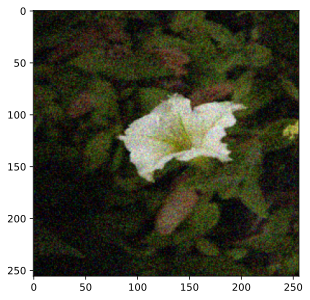

In [5]:
plt.imshow(noise_transform(batch[0])[10].numpy().transpose(1, 2, 0))

In [7]:
def compute_rev_dim(d_in, padding, kernel, stride, output_padding, pooling=1):
    return int((d_in - 1) * stride - 2 * padding + (kernel - 1) + output_padding + 1) // pooling

In [8]:
d = compute_rev_dim(2, padding=1, kernel=3, stride=2, output_padding=1)
print(d)
d = compute_rev_dim(d, padding=1, kernel=3, stride=2, output_padding=1)
d = compute_rev_dim(d, padding=1, kernel=3, stride=2, output_padding=1)
d = compute_rev_dim(d, padding=1, kernel=3, stride=2, output_padding=1)
d = compute_rev_dim(d, padding=1, kernel=3, stride=2, output_padding=1)
d = compute_rev_dim(d, padding=1, kernel=3, stride=2, output_padding=1)
d

4


128

Jedną z ciekawszych obserwacji jest zastosowanie *binarnej entropii krzyżowej* dla obliczania błędu rekonstrukcji, co ma sens w kontekście wartości pikseli z zakresu $[0, 1]$.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\julia\VSCode\PlantTraits2024\models\cnnautoen exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | encoder         | Sequential    | 979 K  | train
1 | decoder         | Sequential    | 1.0 M  | train
2 | criterion       | BCELoss       | 0      | train
3 | noise_transform | GaussianNoise | 0      | train
----------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.985     Total estimated model params siz

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


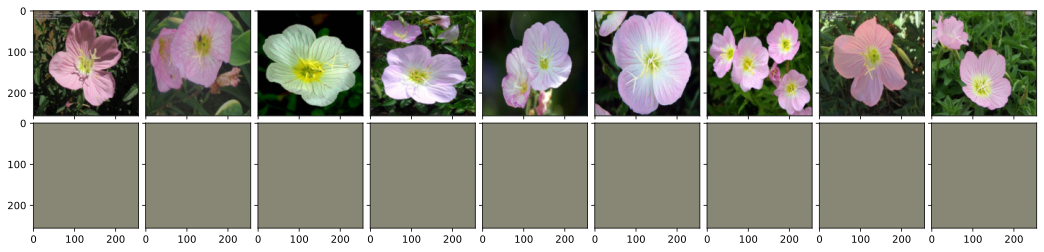

In [9]:
autoencoder = CNNAutoencoder()
checkpoint_dir = Path(f'../models')
os.makedirs(checkpoint_dir, exist_ok=True)
model_name = 'cnnautoen'
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir / model_name, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)
max_epochs = 75

trainer = pl.Trainer(max_epochs=max_epochs, 
                     default_root_dir=checkpoint_dir / model_name, 
                     fast_dev_run=True, # True dla szybkiego przebiegu sprawdzającego, czy wszystkie warstwy są poprawne itd.
                     callbacks=[checkpoint_callback, early_stopping]
                    )

trainer.fit(autoencoder, train_loader, val_loader)

In [10]:
trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=checkpoint_dir / model_name, fast_dev_run=False)
model = CNNAutoencoder.load_from_checkpoint(r'C:\Users\julia\VSCode\PlantTraits2024\models\cnnautoen\epoch=16-val_loss=0.55-train_loss=0.55.ckpt')
_ = model.eval()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
test_recon = trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [12]:
pred = test_recon[0][:9].detach().numpy().transpose(0, 2, 3, 1)
x = next(iter(test_loader))[0][:9].detach().numpy().transpose(0, 2, 3, 1)

Rekonstrukcja na zbiorze testowym

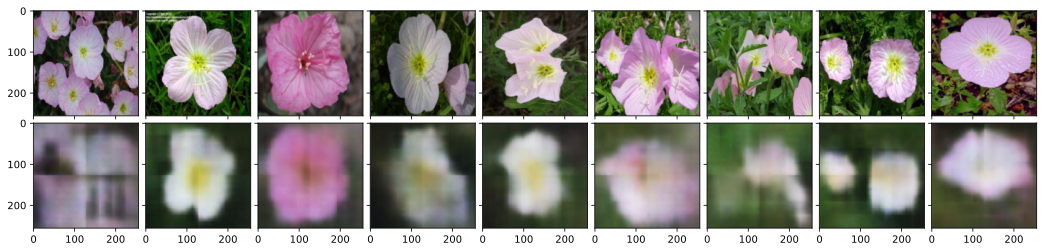

In [13]:
fig = plt.figure(figsize=(18, 8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(2, 9),  # creates 2x9 grid of Axes
                axes_pad=0.1,  # pad between Axes in inch.
                )

for ax, im in zip(grid, [*x, *pred]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

W przypadku konwolucyjnych sieci musimy jeszcze użyć dodatkowej techniki redukcji wymiarowości, aby móc zbadać uzyskane embeddingi. 

In [12]:
from sklearn.manifold import TSNE

latent_vec = []
classes = []
for batch in iter(test_loader):
    latent_vec.append(model.encoder(batch[0]))
    classes.append(batch[1])

latent_vec = torch.concatenate(latent_vec)
latent_vec_flattened = latent_vec.detach().numpy().reshape(len(latent_vec), -1)
classes = torch.concatenate(classes).detach().numpy()

tsne = TSNE(2)
clustered = tsne.fit_transform(latent_vec_flattened)


Docelowo embeddingi powinny tworzyć klastry odpowiadające klasom, ale dla tego zbioru prawdopodobnie zbytnia liczność klas i brak zależności między nimi uniemożliwia uzyskanie takiego efektu.

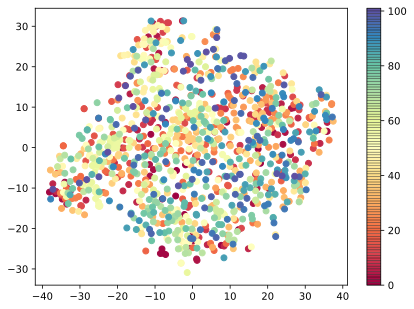

In [13]:
fig = plt.figure(figsize=(7, 5))
cmap = plt.get_cmap('Spectral', 102)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

In [14]:
latent_vec.shape

torch.Size([1020, 256, 2, 2])

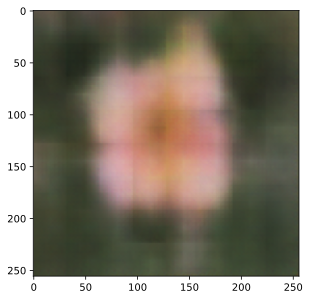

In [15]:
generated_example = model.decoder(latent_vec.mean(0)[None, ...] + latent_vec.var(0)[None, ...] * torch.randn(1, 256, 2, 2))
plt.imshow(generated_example.detach().numpy()[0].transpose(1, 2, 0))

#### Wariancyjne Autoenkodery
Minusem klasycznych autoenkoderów jest to, że nie możemy być pewni co do realizmu wygenerowanych próbek, jeśli nie pochodzą one z podprzestrzeni, której nauczył się ten model. Sposobem na złagodzenie tego efektu jest sprawienie, żeby model nauczył się rozkładu z którego pochodzi dane zdjęcie - w tym przypadku jest to rozkład Gaussa o średniej $\mu=0$ i odchyleniu standardowym $\sigma=1$  ($N(0, 1)$). Funkcja straty łączy więc dwa składniki $$ L = L_{reconstruction} + D_{KL}(P||Q)$$

$L_{reconstruction}$ - strata związana z rekonstrukcją obrazu

$D_{KL}(P||Q)$ - dywergencja Kullbacka-Leiblera, stosowana do obliczania jaki błąd popełniamy przybliżając rozkład Q rozkładem P (pojęcie pochodzące z teorii informacji).

Dekoder na wejściu otrzymuje próbkę z rozkładu przewidzianego przez enkoder. 

W trakcie próbkowania korzystamy z tego, że jeśli mamy $ X \sim N(\mu, \sigma) $, to $ b + aX \sim N(b + a \mu, (a\sigma)^{2}) $. Dzięki temu zmienne *a*, *b* mogą być częścią grafu obliczeniowego i być optymalizowane.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\julia\VSCode\PlantTraits2024\models\cnn-vae exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | encoder   | Sequential | 4.5 M  | train
1 | m_linear  | Linear     | 262 K  | train
2 | v_linear  | Linear     | 262 K  | train
3 | linear    | Sequential | 268 K  | train
4 | decoder   | Sequential | 4.6 M  | train
5 | criterion | BCELoss    | 0      | train
-------------------------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params
39.523    Total est

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


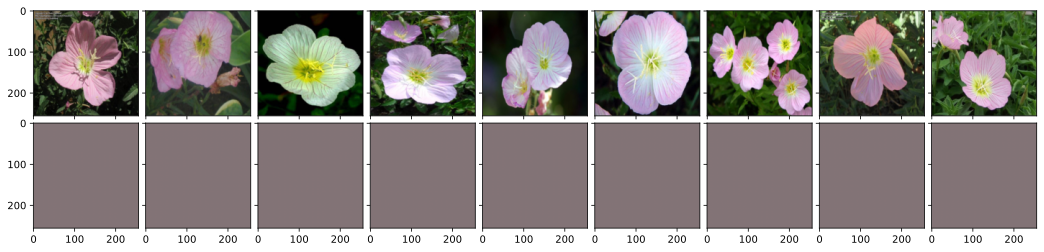

In [3]:
vae_cnn = CNNVAE(z_dim=128, beta=400)
checkpoint_dir = Path(f'../models')
os.makedirs(checkpoint_dir, exist_ok=True)
model_name = 'cnn-vae'
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir / model_name, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(patience=5, monitor='val_loss', verbose=True)
max_epochs = 30

trainer = pl.Trainer(max_epochs=max_epochs, 
                     default_root_dir=checkpoint_dir / model_name, 
                     fast_dev_run=True, # True dla szybkiego przebiegu sprawdzającego, czy wszystkie warstwy są poprawne itd.
                     callbacks=[checkpoint_callback, early_stopping]
                    )

trainer.fit(vae_cnn, train_loader, val_loader)